# Real Estate Price Prediction
## Geekbrains Python for Data Science course competition

In this [competition](https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/overview) your task will be to predict the price of flats in test.csv. You will be given two datasets: train.csv (contains all features and prices of flats) and test.csv (only features).

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

/home/nevl/anaconda3/envs/learn/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

Загрузка данных (для обучения и тестовых)

In [5]:
DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

In [6]:
df = pd.read_csv(DATASET, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
df_test = pd.read_csv(TEST_DATASET, sep=',')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


Изучение имеющихся данных для обучения.

Data fields

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [8]:
# смотрим типы, object заменим на dummy или на ещё что-нибудь
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Целевая переменная (target)

In [9]:
y = df['Price']
y.head()

0    305018.871089
1    177734.553407
2    282078.720850
3    168106.007630
4    343995.102962
Name: Price, dtype: float64

Извлечение целевой перемменной из исходных данных для обучения.

In [10]:
# Удалить из признаков targer
X = df.drop('Price', axis=1, inplace=False)
X.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [11]:
X.shape

(10000, 19)

Оценка данных

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
X.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


Функция для оценки степени точности предсказания

In [14]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

Проверка, что можно сделать с категориальными признаками.

In [15]:
# проверка на сколько категориальные признаки
X['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [16]:
X['Ecology_3'].unique()

array(['B', 'A'], dtype=object)

In [17]:
X['Shops_2'].unique()

array(['B', 'A'], dtype=object)

Т.к. два значения в каждом категориальном признаке, то можно заменить на 0 и 1 => **step 1**

При оценке данных видно, что надо поработать с комнатами.

(array([3.713e+03, 6.115e+03, 1.680e+02, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

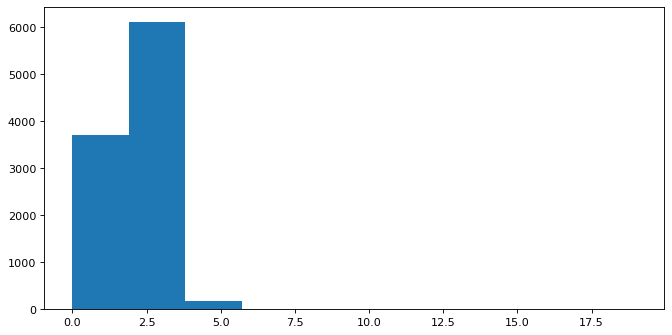

In [18]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X['Rooms'])

(array([18.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 5. ,  5.7,  6.4,  7.1,  7.8,  8.5,  9.2,  9.9, 10.6, 11.3, 12. ,
        12.7, 13.4, 14.1, 14.8, 15.5, 16.2, 16.9, 17.6, 18.3, 19. ]),
 <BarContainer object of 20 artists>)

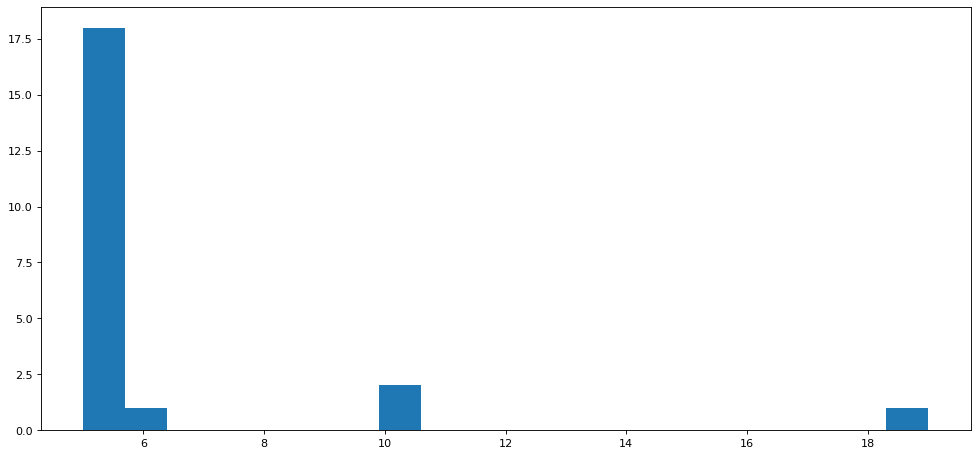

In [19]:
plt.figure(figsize=(15, 7), dpi=80)
plt.hist(X[X['Rooms'] >= 5]['Rooms'], bins=20)

In [20]:
X[X['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B


Из гистограмм видно, что данные о комнатах более 5 похожи на выбросы. Пересчитаем количество комнат для каждой квартиры на основании средней площади => **step 2**

Проведение анализа общей площади и жилой.

Предварительный анализ показывает, что есть квартиры, где общая площать меньше жилой.

In [21]:
X[X['Square'] < X['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B


In [22]:
X[X['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


Можно предположить, что данные перепутали местами при заполнении. Поэтому поменяем местами такие данные => **step 0**

А там где есть пропуски данных посчитаем жилую площадь на основании среднего отношения общей площади к жилой => **step 3**

При оценке данных заметны выбросы в этаже квартиры по отношению к количеству в доме.

In [23]:
X[X['Floor'] > X['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B


Довольно много записей. Как вариант этаж квартиры сделать столько этажей в доме (может даже +1) => **step 4**

Количество этаже в доме тоже вызывает вопросы.

(array([3.916e+03, 5.474e+03, 5.870e+02, 1.700e+01, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([  0. ,  11.7,  23.4,  35.1,  46.8,  58.5,  70.2,  81.9,  93.6,
        105.3, 117. ]),
 <BarContainer object of 10 artists>)

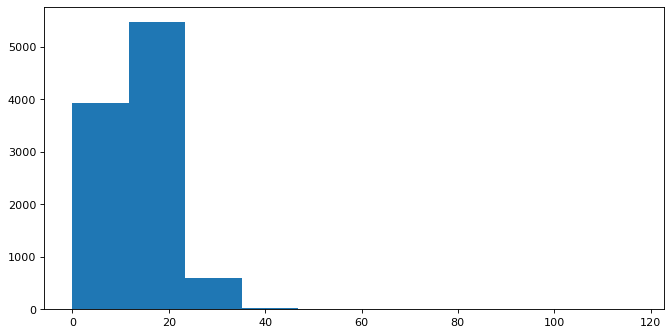

In [24]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X['HouseFloor'])

(array([32., 12.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([ 30. ,  38.7,  47.4,  56.1,  64.8,  73.5,  82.2,  90.9,  99.6,
        108.3, 117. ]),
 <BarContainer object of 10 artists>)

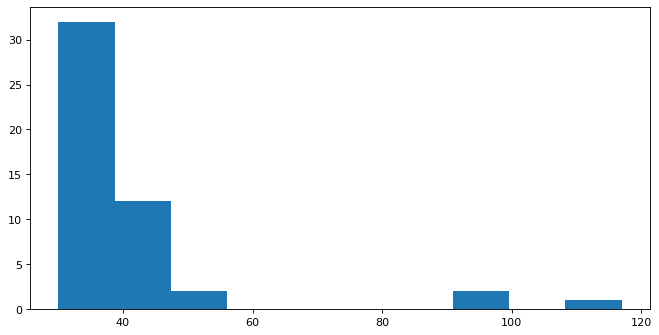

In [25]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X[X['HouseFloor'] >= 30]['HouseFloor'])

In [26]:
X[X['HouseFloor'] > 42]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
646,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
765,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B
4987,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B
5031,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B
5259,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B


Возможно такие дома и сущесвуют, но чтобы выбросы не влияли сильно на модель заменим на максимальное число 42 => **step 5**

Проверка года посткойки дома (на основании оценки данных)

In [27]:
X[X['HouseYear'] > 2022]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B


Всего два дома. В одном видна конкретная ошибка (2005-2011), во втором случае можно догадываться. Заменим на 2005 год постройки => **step 6**

Очередная проверка площади кухни

In [28]:
X[X['KitchenSquare'] >= X['Square'] - X['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
34,7757,27,2.0,58.783661,55.441256,11.0,13,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
42,8576,4,2.0,53.179791,50.643797,5.0,5,12.0,1976,0.042032,B,B,37,6856,84,1940.0,2,5,B
48,12307,60,1.0,40.064914,38.733288,8.0,13,14.0,1974,0.007659,B,B,35,7077,56,2301.0,3,19,B
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B


(array([9.998e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([   0. ,  201.4,  402.8,  604.2,  805.6, 1007. , 1208.4, 1409.8,
        1611.2, 1812.6, 2014. ]),
 <BarContainer object of 10 artists>)

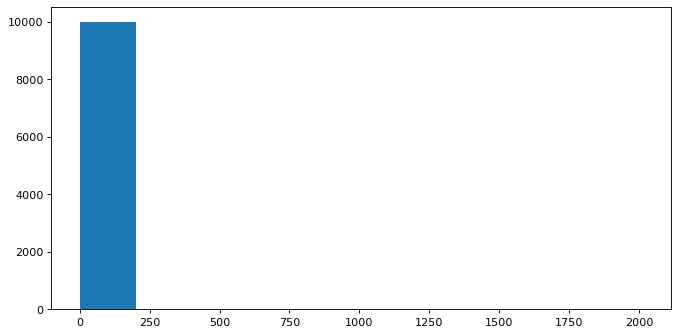

In [29]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X['KitchenSquare'])

(array([8.187e+03, 1.751e+03, 2.300e+01, 1.000e+01, 7.000e+00, 5.000e+00,
        6.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0. ,  9.6, 19.2, 28.8, 38.4, 48. , 57.6, 67.2, 76.8, 86.4, 96. ]),
 <BarContainer object of 10 artists>)

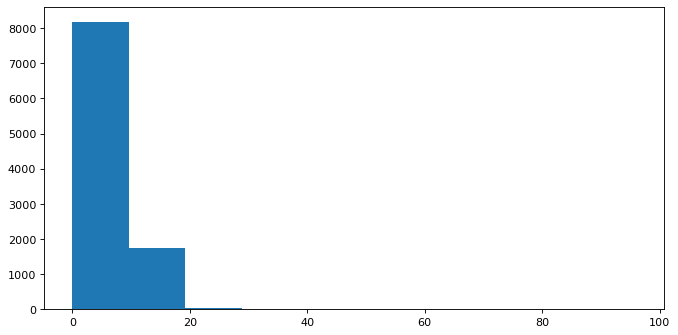

In [30]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X[X['KitchenSquare'] < 100]['KitchenSquare'])

In [31]:
X[X['KitchenSquare'] > 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
277,13559,79,1.0,96.838013,49.140960,22.0,19,24.0,2016,0.050756,B,B,24,5469,1,145.0,0,1,B
286,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B
456,10546,62,1.0,46.013187,43.417043,43.0,4,17.0,2019,0.072158,B,B,2,629,1,NaN,0,0,A
511,8685,62,5.0,124.933289,81.122369,30.0,5,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
682,16593,52,2.0,64.859242,NaN,62.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B
755,15781,10,1.0,35.813564,19.953992,35.0,6,14.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B
1614,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
1728,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B


Очевидно, что здесь какие-то выбросы (даже с учётом того, что площадь квартиры превышает сумму кухни и жилой площади). С этим можно поработать отдельно. А пока будем делить (два раза) площадь превышающую 20 м => **step 7**

В данных есть столбец `Id`, который не несёт смысловой нагрузки и может привести к некорректному обучению модели. Удалим этот столбец => **step8**

Изучение оставшихся пропусков

In [32]:
X[X['Healthcare_1'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,88.931509,0.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B


(array([1354., 1277., 1224.,  314.,  409.,  369.,   43.,   42.,   82.,
          88.]),
 array([   0. ,  484.9,  969.8, 1454.7, 1939.6, 2424.5, 2909.4, 3394.3,
        3879.2, 4364.1, 4849. ]),
 <BarContainer object of 10 artists>)

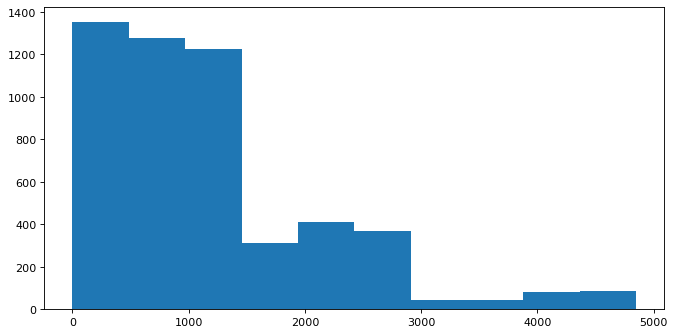

In [33]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(X[X['Healthcare_1'].notna()]['Healthcare_1'])

Довольно много пропусков. И довольно странное распределение. Чтобы минимально потерять данные возьмём 91-перцентиль => **step9**

Для ускорения обучения модели, но с сохранением всех данных сделаем приведение типов к более малым размерам => **step10**

## Подготовка pipeline-а для подготовки и обучения модели

In [34]:
def step0(df):
    df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))
    return df

In [35]:
def step1(df):
    # step 1
    df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
    df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
    df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
    df['Ecology_2'] = df['Ecology_2'].astype(np.int8)
    df['Ecology_3'] = df['Ecology_3'].astype(np.int8)
    df['Shops_2'] = df['Shops_2'].astype(np.int8)
    return df

In [36]:
def step2(df, medians):
    mask = (df['Rooms'] > 6) | (df['Rooms'] < 1)   
    room_square = np.round((medians.LifeSquare / medians.Rooms, 1))[0]
    df.fillna(df['LifeSquare'] / room_square)
#     print('Room square = ', room_square)
#     print(df[df['Rooms'].isna()])
    df.loc[mask , 'Rooms'] = df.loc[mask, 'LifeSquare'] / room_square
    df['Rooms'] = df['Rooms'].astype(np.int8)
    return df

In [37]:
def step3(df):
    t = (df['LifeSquare'] / df['Square']).mean()

    df['LifeSquare'].fillna(df['Square'] * t, inplace=True)

    df['Square'] = df['Square'].astype(np.float32)
    df['LifeSquare'] = df['LifeSquare'].astype(np.float32)

    # print('step3 ', df[df['Square'] < df['LifeSquare']].shape)
    return df

In [38]:
def step4(df):
    # step 4
    df['HouseFloor'] = df['HouseFloor'].astype(np.int8)
    df['Floor'] = df['Floor'].astype(np.int8)

    vals = df[df['Floor'] > df['HouseFloor']]
    mask = df['Floor'] > df['HouseFloor']
    # этаж квартиры, как макс этажей дома
    new_vals = df[mask]['HouseFloor']
    vals.loc[mask, 'Floor'] = new_vals.values

    df.loc[mask, 'Floor'] = new_vals.values
    # print('step 4 ', X.shape)
    return df

In [39]:
def step5(df):
    # step 5
    df.loc[df['HouseFloor'] > 42, 'HouseFloor'] = 42
    return df

In [40]:
def step6(df):
    # step 6
    df['HouseYear'] = df['HouseYear'].astype(np.int16)
    df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2005
    return df

In [41]:
def step7(df):
    # step 7
    df['KitchenSquare'] = df['KitchenSquare'].astype(np.float32)
    mask = df['KitchenSquare'] > 20
    new_vals = df.loc[mask, 'KitchenSquare'] / 10.0
    new_vals = new_vals.astype(np.int32).astype(np.float32)
    new_vals.loc[new_vals > 20] = 10
    df.loc[mask, 'KitchenSquare'] = new_vals
    return df

In [42]:
def step8(df, is_test):
    # step 8: Убрать ID
    if not is_test:
        df.drop(['Id'], axis=1, inplace=True)
    return df

In [43]:
def step9(df, medians, district_healthcare):
    # step 9: fill NA
    df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(district_healthcare)
    df['Healthcare_1'].fillna(medians.Healthcare_1, inplace=True)       
    q_max = np.quantile(df['Healthcare_1'], q=0.91)
    df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
    df['Healthcare_1'] = df['Healthcare_1'].astype(np.float32)
    return df

In [44]:
def step10(df):
    df['DistrictId'] = df['DistrictId'].astype(np.int8)
    df['Ecology_1'] = df['Ecology_1'].astype(np.float32)
    df['Social_2'] = df['Social_2'].astype(np.int32)
    df['Social_3'] = df['Social_3'].astype(np.int16)
    df['Social_1'] = df['Social_1'].astype(np.int8)
    df['Helthcare_2'] = df['Helthcare_2'].astype(np.float32)
    df['Shops_1'] = df['Shops_1'].astype(np.int8)
    return df

In [45]:
class DataPipeline:
    
    def __init__(self):
        self.medians = None
        print("New pipeline")
    
    def fit(self, df):
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))
        self.medians = df.median()
        
        self.district_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
        return df
    
    def transform(self, dataframe, is_test=False):
        print(dataframe.columns)
        df = dataframe.copy()
        df = step0(df)
        
        df = step1(df)
        
        df = step3(df)

        df = step2(df, self.medians)
     
        df = step4(df)
        
        df = step5(df)
        
        df = step6(df)

        df = step7(df)
        
        df = step8(df, is_test=is_test)
        
        df = step9(df, self.medians, self.district_healthcare)
        
        df = step10(df)

        return df

In [46]:
data_pipe = DataPipeline()
X = data_pipe.fit(X)
X = data_pipe.transform(X)
X2 = data_pipe.transform(df_test, is_test=True)

New pipeline
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')


/tmp/ipykernel_94652/2358076533.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.medians = df.median()
/tmp/ipykernel_94652/1343025639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals.loc[mask, 'Floor'] = new_vals.values
/tmp/ipykernel_94652/1343025639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals.loc[mask, 'Flo

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int8   
 1   Rooms          10000 non-null  int8   
 2   Square         10000 non-null  float32
 3   LifeSquare     10000 non-null  float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  int8   
 7   HouseYear      10000 non-null  int16  
 8   Ecology_1      10000 non-null  float32
 9   Ecology_2      10000 non-null  int8   
 10  Ecology_3      10000 non-null  int8   
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int32  
 13  Social_3       10000 non-null  int16  
 14  Healthcare_1   10000 non-null  float32
 15  Helthcare_2    10000 non-null  float32
 16  Shops_1        10000 non-null  int8   
 17  Shops_2        10000 non-null  int8   
dtypes: floa

# Learning

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8446)

Линейная регрессия, чтобы понять на сколько можно пользоваться данными.

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [50]:
y_train_preds = lr.predict(X_train)
y_pred = lr.predict(X_test)
y_pred.shape, r2(y_test, y_pred)

((2000,), 0.471789016415177)

R2:	0.448
RMSE:	69040.735
MSE:	4766623094.21


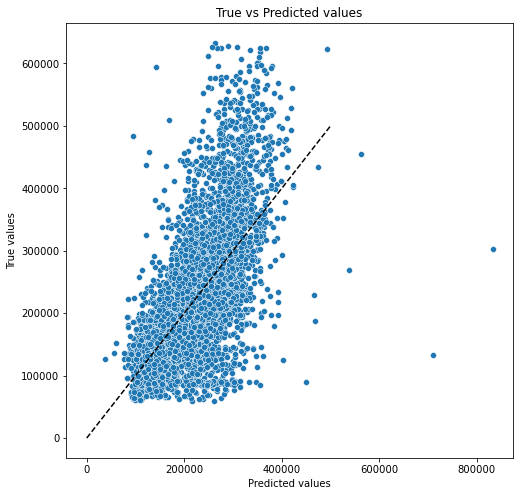

In [51]:
evaluate_preds(y_train, y_train_preds)

R2:	0.472
RMSE:	67358.839
MSE:	4537213143.69


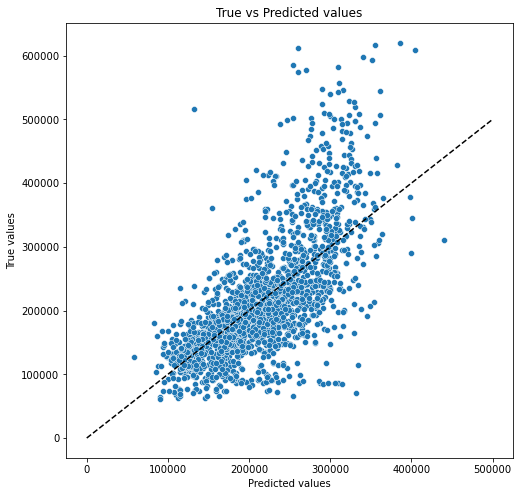

In [52]:
y_test_preds = lr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Случайный лес

R2:	0.726
RMSE:	48649.239
MSE:	2366748455.966


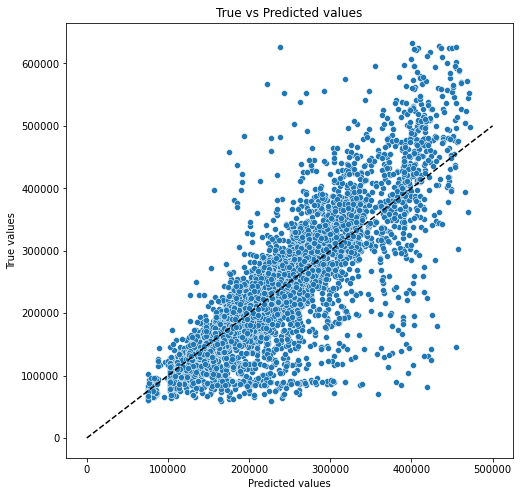

In [53]:
rf_model = RandomForestRegressor(criterion='squared_error',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=8446,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.684
RMSE:	52125.179
MSE:	2717034337.106


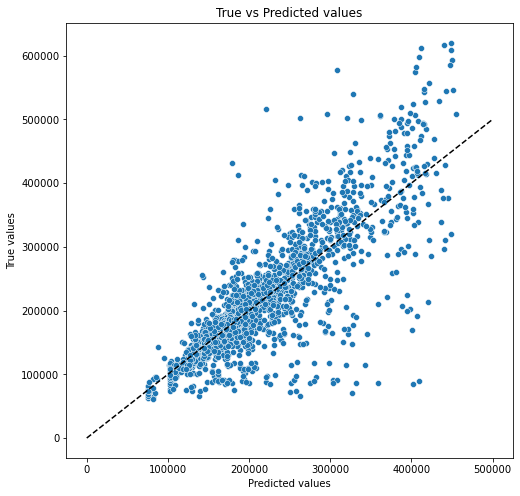

In [54]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

13/04/2022 nevl Score: **0.65869**

#### Градиентный спуск

In [55]:
gb_model = GradientBoostingRegressor(criterion='squared_error',
                          min_samples_leaf=10,
#                           random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [56]:
# %%time
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10],
#              'random_state':[42, 8446, 4174]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1,
#                   verbose=10
#                   )
# gs.fit(X_train, y_train)

In [57]:
# gs.best_params_
# {'max_depth': 5, 'n_estimators': 200, 'random_state': 42}

In [58]:
# gs.best_score_
# 0.7404828015401833

In [59]:
final_model = GradientBoostingRegressor(criterion='squared_error',
                          min_samples_leaf=10,
                          random_state=42,
                         n_estimators=200,
                         max_depth=5
                         )

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', max_depth=5,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=42)

R2:	0.877
RMSE:	32598.561
MSE:	1062666151.678


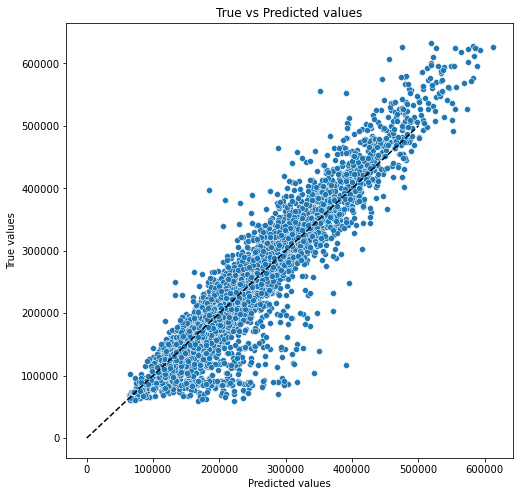

In [60]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.747
RMSE:	46574.715
MSE:	2169204104.547


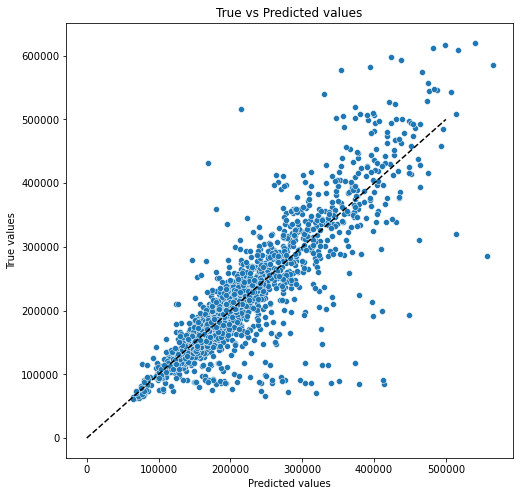

In [61]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

12/04/2022 nevl Score: **0.73232** Place: 218

In [62]:
gb_model = xgb.XGBRegressor(
#                              colsample_bytree=0.4445,
#                              learning_rate=0.01,
#                              max_depth=6,
#                              min_child_weight=0.09,
#                              n_estimators=1000,
#                              reg_lambda=0.6,
#                              random_state=7
                            )

In [63]:
# %%time
# params = {
#     'colsample_bytree':[0.444, 0.4445, 0.445],
#     'learning_rate':[0.01, 0.012, 0.008],
#     'max_depth':[5, 6, 7, 8, 9, 10],
#     'min_child_weight':[0.09, 0.092, 0.088], 
#     'n_estimators':[800, 1000, 2000, 5000],
#     'reg_lambda':[0.5, 0.6, 0.7],
#     'random_state':[7, 42, 4174, 8446]
# }

# gs = GridSearchCV(gb_model, params,
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                       random_state=21, 
#                       shuffle=True),
#                   n_jobs=-1,
#                   verbose=10
#                   )
# gs.fit(X_train, y_train)

In [64]:
# gs.best_params_

In [65]:
# gs.best_score_

In [66]:
final_model = xgb.XGBRegressor(
                             colsample_bytree=0.4445, # 0.4445
                             learning_rate=0.01, #0.015
                             max_depth=6, # 6
                             min_child_weight=0.09, # 0.1 
                             n_estimators=1000, # 1000
                             reg_lambda=0.6, # 0.6
                             random_state=7 # 7
                            )

/home/nevl/anaconda3/envs/learn/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


R2:	0.889
RMSE:	30891.853
MSE:	954306558.904


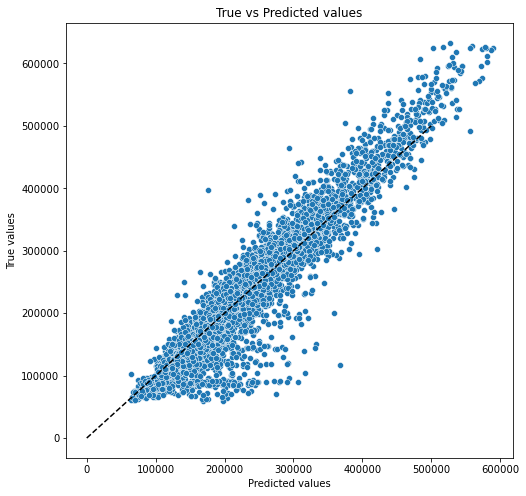

In [67]:
final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_train, y_train_preds)

R2:	0.75
RMSE:	46382.682
MSE:	2151353150.398


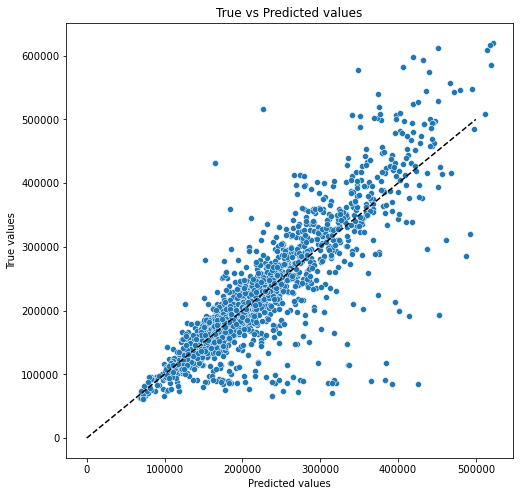

In [68]:
evaluate_preds(y_test, y_test_preds)

13/04/2022 nevl Score: **0.73738** Place: 171

# Store results

In [69]:
samples = pd.read_csv('sample_submission.csv')
samples.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [70]:
samples.shape

(5000, 2)

In [71]:
y_preds = final_model.predict(X2.drop(['Id'], axis=1))
y_preds

array([160243.45, 128518.38, 153170.84, ..., 144753.81, 191719.94,
       275213.22], dtype=float32)

In [72]:
X2['Price'] = y_preds
X2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,1,1,24,4378,0,1036.0,1.0,1,1,160243.453125
1,5925,62,1,42.568134,42.493908,10.0,7,17,2017,0.072158,1,1,2,629,1,2300.0,0.0,0,0,128518.382812
2,960,27,2,59.463676,38.276161,9.0,19,19,1977,0.211401,1,1,9,1892,0,900.0,0.0,1,1,153170.843750
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,1,1,2,475,0,0.0,0.0,0,1,123805.179688
4,746,74,1,53.837055,34.654362,1.0,8,17,1977,0.309479,1,1,35,7715,4,990.0,0.0,6,1,194059.734375


In [73]:
X2[['Id','Price']].head()

,Id,Price
0,4567,160243.453125
1,5925,128518.382812
2,960,153170.843750
3,3848,123805.179688
4,746,194059.734375


In [74]:
X2[['Id','Price']].shape

(5000, 2)

In [75]:
X2[['Id','Price']].to_csv('price_submit.csv', index=False)

## Выводы

Модель/и можно совершенствовать и далее. Можно по другому подготовить признаки. Посчитать или предсказать. Попробовать выкинуть какие-то данные. Разбить на кластеры и добавить такие признаки. Можно из существующих признаков посоздавать ещё признаки.

Вариантов куча. Нужно только терпение и время.